# Test of repetitive control

PH, June 2019


Repetitive control connected to a simple process:

* fast 1st order dyn
* static gain=0.8
<img src='figures/testCtrl.png' width='50%'>

dependencies to run OM and load results

* OMPython: [OMPython doc](https://openmodelica.org/doc/OpenModelicaUsersGuide/latest/ompython.html)
* DyMat: https://pypi.org/project/DyMat/, [Tuto DyMat](https://www.fabrice-salvaire.fr/en/blog/first-steps-with-openmodelica/)

In [1]:
from pathlib import Path
import os
import subprocess

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from OMPython import OMCSessionZMQ, ModelicaSystem

In [4]:
import DyMat

Launch OpenModelica test

In [5]:
omc = OMCSessionZMQ()

2019-07-02 16:15:05,693 - OMPython - INFO - OMC Server is up and running at file:////tmp/openmodelica.pierre.port.bbc819186dbb4963b45a311a0b008d12 pid=3987


OpenModelica version:

In [6]:
omc.sendExpression("getVersion()")

'OpenModelica 1.13.2'

## Load model

Change current working directory to `./tmp` to avoid file clutter

In [7]:
os.chdir('tmp')

In [9]:
f = Path('../MagneticTestCtrl.mo')
f.absolute()

PosixPath('/home/pierre/Travail/42 Projets/2019-06 MagTestCtrl/tmp/../MagneticTestCtrl.mo')

Load and build model in `tmp` dir

In [10]:
mod = ModelicaSystem(f.absolute(), 'MagneticTestCtrl.tests.testCtrl')

2019-07-02 16:15:35,971 - OMPython - INFO - OMC Server is up and running at file:////tmp/openmodelica.pierre.port.59603b41c5664ef4babf2fd07fc56955 pid=4016


Notification: Automatically loaded package Modelica 3.2.2 due to uses annotation.
Notification: Automatically loaded package Complex 3.2.2 due to uses annotation.
Notification: Automatically loaded package ModelicaServices 3.2.2 due to uses annotation.



In [11]:
mod.modelName

'MagneticTestCtrl.tests.testCtrl'

In [12]:
mod.getParameters()

{'aPert': 1.0,
 'addPert.k1': 1.0,
 'addPert.k2': 1.0,
 'ctrl.add.k1': 1.0,
 'ctrl.add.k2': 1.0,
 'ctrl.addFF.k1': 1.0,
 'ctrl.addFF.k2': 1.0,
 'ctrl.delay.delayTime': 1.0,
 'ctrl.f0': None,
 'ctrl.fc': 1000.0,
 'ctrl.ffg': 1.0,
 'ctrl.firstOrder.T': 1.0,
 'ctrl.firstOrder.k': 1.0,
 'ctrl.firstOrder.y_start': 0.0,
 'ctrl.gainFB.k': 1.0,
 'ctrl.gainFF.k': 1.0,
 'ctrl.k': 1.25,
 'ctrl.td': None,
 'f0': 50.0,
 'phasePert': 0.0,
 'process.T': 1e-05,
 'process.k': 0.8,
 'process.y_start': 0.0,
 'ref.amplitude': 2.0,
 'ref.offset': -1.0,
 'ref.period': 1.0,
 'ref.startTime': 0.0,
 'ref.width': 50.0,
 'refFilter.T': 1e-05,
 'refFilter.k': 1.0,
 'refFilter.y_start': 0.0,
 'sinePert.amplitude': None,
 'sinePert.freqHz': 1.0,
 'sinePert.offset': 0.0,
 'sinePert.phase': None,
 'sinePert.startTime': None,
 'startTimePert': 0.0,
 'ctrl.firstOrder.initType': 1.0,
 'n': 3.0,
 'process.initType': 1.0,
 'ref.nperiod': -1.0,
 'refFilter.initType': 1.0,
 'ctrl.compLag': 1.0}

## A first simulation

How to change parameters:

In [29]:
mod.setParameters(**{'ctrl.k':3})

In [30]:
mod.getParameters('ctrl.k', 'sinePert.freqHz') # nb : bug when asking for just one param (https://github.com/OpenModelica/OMPython/issues/96)

(3.0, 1.0)

nb : in fact in Modelica code, `sinePert.freqHz` is set to `n * f0` (=150 Hz), so the display 1.0 is wrong

In [15]:
mod.getSimulationOptions()

{'startTime': 0.0,
 'stopTime': 0.2,
 'stepSize': 1e-05,
 'tolerance': 1e-06,
 'solver': 'dassl'}

set the step size

In [103]:
stopTime = 0.3 # s
mod.setSimulationOptions(stopTime = stopTime, stepSize = 1e-6)

Simulate: BUG in OMPython

In [17]:
mod.simulate() # does nothing..

Fixed simulate method: (inspired by the code of the original `ModelicaSystem.simulate` method)

In [105]:
def simulate(mod):
    r = subprocess.run([Path(mod.modelName).absolute()], capture_output=True)
    print(r.stdout.decode())
    return r

In [106]:
simulate(mod);

LOG_SUCCESS       | info    | The initialization finished successfully without homotopy method.
LOG_SUCCESS       | info    | The simulation finished successfully.



### get results

* using getSolutions: too long
* much faster with DynMat

In [107]:
# ym = mod.getSolutions('magCtrl.ym') ## too long

In [108]:
res = DyMat.DyMatFile('MagneticTestCtrl.tests.testCtrl_res.mat')

In [109]:
t = res.abscissa('ctrl.ym')[0]
t= t*1000 # -> ms
u = res.data('process.u')
ym = res.data('ctrl.ym')
ysp = res.data('ctrl.ysp')

Plot simulation with zoom on last period

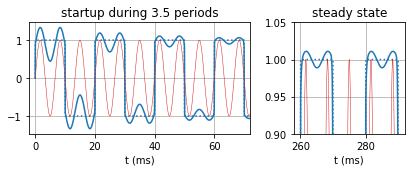

In [143]:
def plot_data(ax, res):
    t = res.abscissa('ctrl.ym')[0]
    t= t*1000 # -> ms
    u = res.data('process.u')
    ym = res.data('ctrl.ym')
    ysp = res.data('ctrl.ysp')
    w = res.data('sinePert.y')

    ax.plot(t,ysp, 'C0:')
    ax.plot(t,ym, 'C0-')
    #ax.plot(t,u)
    ax.plot(t,w, 'C3', lw=0.5)

    ax.grid()
    ax.set(
        xlabel='t (ms)'
    )

def plot_res_ss(res, axes=None, n1=3.5, n2=2, y2=(0.9, 1.05)):
    T0 = 1/res.data('f0')[0]*1e3 # period in ms
    
    if not axes:
        fig, (ax1, ax3) = plt.subplots(1,2, figsize=(6,2.5),
                                       gridspec_kw=dict(width_ratios=[2, 1]))
    else:
        ax1, ax3 = axes
        fig = ax1.get_figure()

    plot_data(ax1, res)
    ax1.set(
        xlim = (-n1*T0*0.03,n1*T0*1.03),
        title = f'startup during {n1} periods'
    )
    #plot_data(ax2)
    #ax2.set(
    #    xlim = (-5,55),
    #    ylim = (0.7, 1.1)
    #)
    plot_data(ax3, res)
    T = stopTime*1e3
    dT = 0.05*T0*n2
    ax3.set(
        xlim = (T-n2*T0-dT, T-0.5*T0+dT),
        ylim = (y2[0], y2[1]),
        title = 'steady state'
    )
    fig.tight_layout()

plot_res_ss(res)

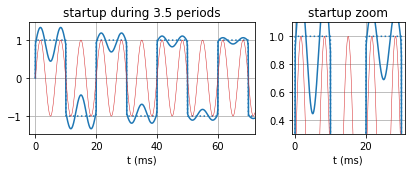

In [148]:
def plot_res_trans(res, axes=None, n1=3.5, n2=1.5, y2=(0.3, 1.1)):
    T0 = 1/res.data('f0')[0]*1e3 # period in ms
    
    if not axes:
        fig, (ax1, ax3) = plt.subplots(1,2, figsize=(6,2.5),
                                       gridspec_kw=dict(width_ratios=[2, 1]))
    else:
        ax1, ax3 = axes
        fig = ax1.get_figure()

    plot_data(ax1, res)
    ax1.set(
        xlim = (-n1*T0*0.03,n1*T0*1.03),
        title = f'startup during {n1} periods'
    )
    #plot_data(ax2)
    #ax2.set(
    #    xlim = (-5,55),
    #    ylim = (0.7, 1.1)
    #)
    plot_data(ax3, res)
    ax3.set(
        xlim = (-n2*T0*0.03,n2*T0*1.03),
        ylim = (y2[0], y2[1]),
        title = 'startup zoom'
    )
    fig.tight_layout()

plot_res_trans(res)

## Parametric analysis

Nominal params

In [49]:
params_nom = {
    'aPert': 1.0, # aplitude of perturbation
    'n': 3, # harmonic of perturbation
    'ctrl.k': 1.0, # feedback gain
    'ctrl.fc': 1e3, # Hz
    'ctrl.ffg': 1.0 # feedforward gain
}

Simulate with variants

In [65]:
def simulate_variant(params, params_nom):
    # reset to nominal params
    mod.setParameters(**params_nom)
    # apply specific params
    mod.setParameters(**params)
    # Sim
    simulate(mod)
    # extract results
    res = DyMat.DyMatFile(mod.modelName + '_res.mat')
    # reset to nominal params
    mod.setParameters(**params_nom)
    return res

## Perturbation rejection

* sinusoid at $3.f_0$=150 Hz, amplitude 1
* $f_c$ = 1e3


$$\frac{y}{w} \approx \frac{1}{2K} \left( \frac{nf_0}{f_c}\right)^2$$

Numerical examples:

* 150 Hz perturbation: attenuation down to 1.1% with gain K=1, 0.56% with K=2
* 250 Hz perturbation: attenuation down to 1.56% with gain K=2


In [61]:
K = 1
n = 3
f0 = 50
fc = 1e3
((n*f0)/fc)**2 / (2*K)

0.01125

In [59]:
K = 2

((n*f0)/fc)**2 / (2*K)

0.005625

In [60]:
K = 2
n = 5

((n*f0)/fc)**2 / (2*K)

0.015625

In [150]:
variants = {}

variants['n3_K1'] = params_nom.copy()

variants['n3_K2'] = params_nom.copy()
variants['n3_K2']['ctrl.k'] = 2.

variants['n5_K2'] = variants['n3_K2'].copy()
variants['n5_K2']['n'] = 5

variants

{'n3_K1': {'aPert': 1.0,
  'n': 3,
  'ctrl.k': 1.0,
  'ctrl.fc': 1000.0,
  'ctrl.ffg': 1.0},
 'n3_K2': {'aPert': 1.0,
  'n': 3,
  'ctrl.k': 2.0,
  'ctrl.fc': 1000.0,
  'ctrl.ffg': 1.0},
 'n5_K2': {'aPert': 1.0,
  'n': 5,
  'ctrl.k': 2.0,
  'ctrl.fc': 1000.0,
  'ctrl.ffg': 1.0}}

Run all the simulations

In [151]:
res_dict = {}
for v, params in variants.items():
    res_dict[v] = simulate_variant(params, params_nom)
res_dict

LOG_SUCCESS       | info    | The initialization finished successfully without homotopy method.
LOG_SUCCESS       | info    | The simulation finished successfully.

LOG_SUCCESS       | info    | The initialization finished successfully without homotopy method.
LOG_SUCCESS       | info    | The simulation finished successfully.

LOG_SUCCESS       | info    | The initialization finished successfully without homotopy method.
LOG_SUCCESS       | info    | The simulation finished successfully.



{'n3_K1': <DyMat.DyMatFile at 0x7f3bfa8bee48>,
 'n3_K2': <DyMat.DyMatFile at 0x7f3bf6ce6b70>,
 'n5_K2': <DyMat.DyMatFile at 0x7f3bf93f4278>}

Plots perturbation rejection

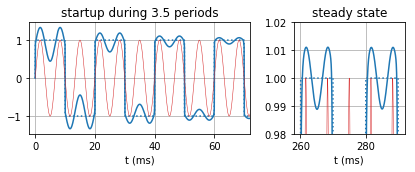

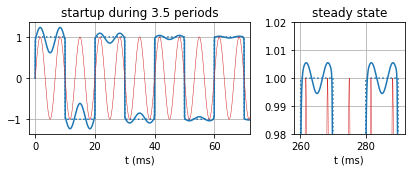

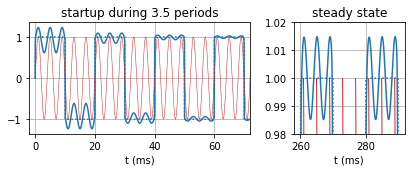

In [152]:
plot_res_ss(res_dict['n3_K1'], y2 = (0.98, 1.02))
plt.savefig('../testCtrl_n3_K1.png', dpi=200)
plot_res_ss(res_dict['n3_K2'], y2 = (0.98, 1.02))
plt.savefig('../testCtrl_n3_K2.png', dpi=200)
plot_res_ss(res_dict['n5_K2'], y2 = (0.98, 1.02))
plt.savefig('../testCtrl_n5_K2.png', dpi=200)

## Convergence speed

without feedforward, and no perturbation, one should observe that
* tracking error at first period is $\frac{1}{1+KH}$
* at each period, this decays with $\frac{1}{1+KH}$

In [121]:
H = mod.getParameters('process.k', 'aPert')[0]
H

0.8

In [117]:
1/(1+1)

0.5

In [118]:
1/(1+3)

0.25

In [153]:
variants = {}

variants['track_KH1_ffg0'] = params_nom.copy()
variants['track_KH1_ffg0']['aPert'] = 0
variants['track_KH1_ffg0']['ctrl.k'] = 1/H # KH =1
variants['track_KH1_ffg0']['ctrl.ffg'] = 0

variants['track_KH1_ffg1'] = variants['track_KH1_ffg0'].copy()
variants['track_KH1_ffg1']['ctrl.ffg'] = 1

variants['track_KH3_ffg0'] = variants['track_KH1_ffg0'].copy()
variants['track_KH3_ffg0']['ctrl.k'] = 3/H # KH =3

variants

{'track_KH1_ffg0': {'aPert': 0,
  'n': 3,
  'ctrl.k': 1.25,
  'ctrl.fc': 1000.0,
  'ctrl.ffg': 0},
 'track_KH1_ffg1': {'aPert': 0,
  'n': 3,
  'ctrl.k': 1.25,
  'ctrl.fc': 1000.0,
  'ctrl.ffg': 1},
 'track_KH3_ffg0': {'aPert': 0,
  'n': 3,
  'ctrl.k': 3.75,
  'ctrl.fc': 1000.0,
  'ctrl.ffg': 0}}

Run all simulations

In [154]:
res_dict = {}
for v, params in variants.items():
    res_dict[v] = simulate_variant(params, params_nom)
res_dict

LOG_SUCCESS       | info    | The initialization finished successfully without homotopy method.
LOG_SUCCESS       | info    | The simulation finished successfully.

LOG_SUCCESS       | info    | The initialization finished successfully without homotopy method.
LOG_SUCCESS       | info    | The simulation finished successfully.

LOG_SUCCESS       | info    | The initialization finished successfully without homotopy method.
LOG_SUCCESS       | info    | The simulation finished successfully.



{'track_KH1_ffg0': <DyMat.DyMatFile at 0x7f3bf88c6940>,
 'track_KH1_ffg1': <DyMat.DyMatFile at 0x7f3bf8a7f780>,
 'track_KH3_ffg0': <DyMat.DyMatFile at 0x7f3bf6e77978>}

Plots startup convergence

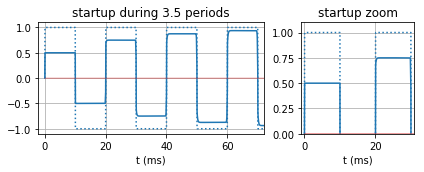

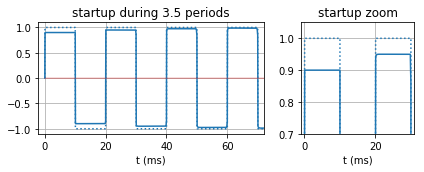

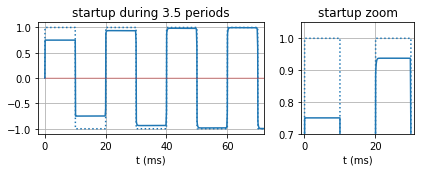

In [169]:
plot_res_trans(res_dict['track_KH1_ffg0'], y2=(0., 1.1))
plt.savefig('../testCtrl_track_KH1_ffg0.png', dpi=200)

plot_res_trans(res_dict['track_KH1_ffg1'], y2=(0.7, 1.05))
plt.savefig('../testCtrl_track_KH1_ffg1.png', dpi=200)

plot_res_trans(res_dict['track_KH3_ffg0'], y2=(0.7, 1.05))
plt.savefig('../testCtrl_track_KH3_ffg0.png', dpi=200)

Check numbers for the case KH=3:

In [168]:
1-1/4, 1-(1/4)**2

(0.75, 0.9375)